## Data Scientist salaries

A fun dataset showing data scientist salaries. Source: [Kaggle](https://www.kaggle.com/datasets/henryshan/2023-data-scientists-salary?resource=download).

This exploratory notebook shows some analysis and attempts to make predictions for salaries.

By Ali Shannon

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import torch
from torch import nn, optim

Reading the dataset and showing the columns

In [2]:
df = pd.read_csv("ds_salaries.csv")

print(df.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')


### Preprocessing steps for plots

Some data preprocessing is necessary for visualization and organization purposes. The information here is from the metadata on the Kaggle page.

In [3]:
full_names = {
    "experience_level": {
        "EN": "Entry-level / Junior",
        "MI": "Mid-level / Intermediate",
        "SE": "Senior-level / Expert",
        "EX": "Executive-level / Director"
    },
    "employment_type": {
        "PT": "Part-time",
        "FT": "Full-time",
        "CT": "Contract",
        "FL": "Freelance"
    }
}

for col_name, col_data in df.items():
    if col_name in full_names:
        df[col_name] = col_data.apply(lambda row: full_names[col_name][row])
    if col_data.dtype == np.dtype('O'):
        df[col_name] = col_data.astype("category")


The following is an encoder, similar to one_hot_encoder but uses an array of numerical codes instead of sparse matrices to replace categorical data. This will come in handy later for machine learning applications.

In [4]:
def encode_df(df):
    encoded_df = df.copy()
    category_cols = encoded_df.select_dtypes(['category']).columns
    encoded_df[category_cols] = encoded_df[category_cols].apply(lambda x: x.cat.codes)
    return encoded_df

encode_df(df=df.sample(9))

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3137,2022,3,2,69,131300,19,131300,75,100,70,0
2629,2022,3,2,33,129300,19,129300,75,0,70,1
1705,2022,0,3,25,24000,7,25216,26,100,70,0
1512,2023,0,2,47,1060000,12,12888,39,50,38,2
2378,2022,0,3,11,12000,19,12000,54,100,70,0
326,2023,2,2,69,150450,19,150450,75,100,70,1
2849,2022,3,2,53,55000,7,57786,28,50,27,0
1828,2022,3,2,42,122000,19,122000,75,0,70,1
2759,2022,3,2,47,141525,19,141525,75,100,70,1


The total salary distribution for the dataset

count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64


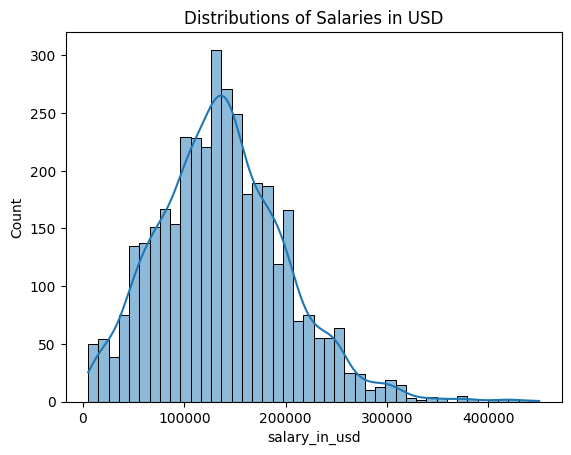

In [5]:
print(df['salary_in_usd'].describe())
sns.histplot(data=df, x="salary_in_usd", kde=True).set(title="Distributions of Salaries in USD")
plt.show()

US salaries vs all other countries

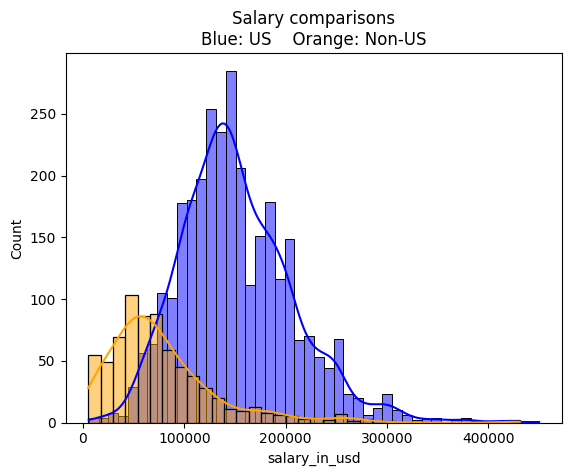

In [6]:
us_companies = df[df["company_location"] == "US"].loc[:, df.columns != 'company_location']
non_us_companies = df[df["company_location"] != "US"]

fig, ax = plt.subplots()

sns.histplot(data=us_companies, x="salary_in_usd", color="blue", kde=True).set(label="US Companies")
sns.histplot(data=non_us_companies, x="salary_in_usd", color="orange", kde=True).set(label="Non US Companies")
ax.set_title("Salary comparisons\nBlue: US    Orange: Non-US")
plt.show()

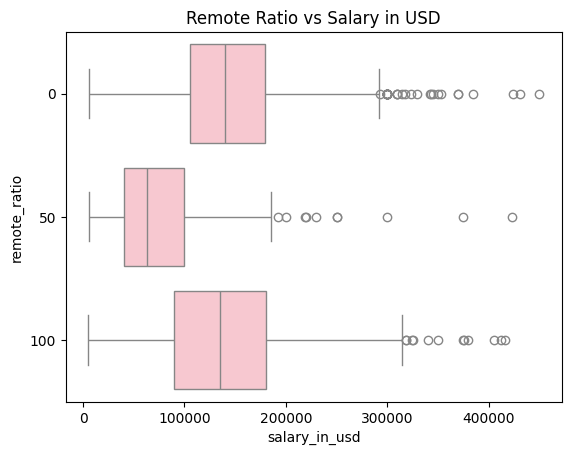

In [7]:
sns.boxplot(
    data=df,
    x="salary_in_usd",
    y="remote_ratio",
    orient="h",
    color="pink"
).set(title="Remote Ratio vs Salary in USD")
plt.show()

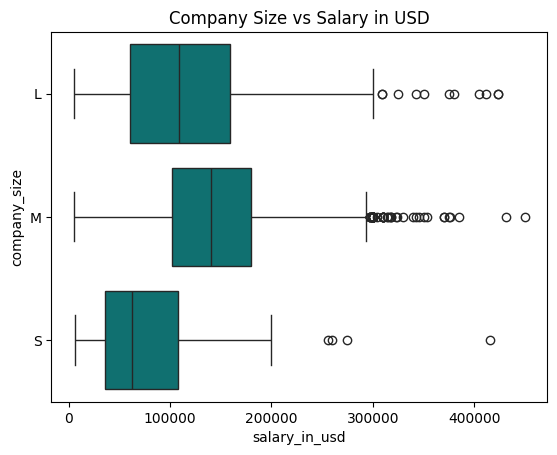

In [8]:
sns.boxplot(
    data=df,
    x="salary_in_usd",
    y="company_size",
    orient="h",
    color="teal",
).set(title="Company Size vs Salary in USD")

plt.show()

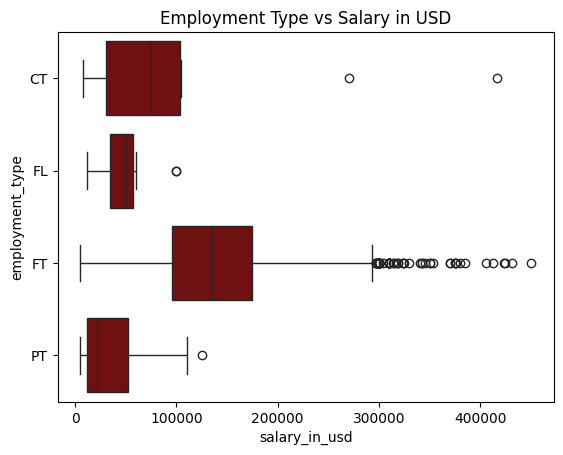

In [9]:
sns.boxplot(
    data=df,
    x="salary_in_usd",
    y="employment_type",
    orient="h",
    color=("maroon", 0.3)
).set(title="Employment Type vs Salary in USD")
plt.show()

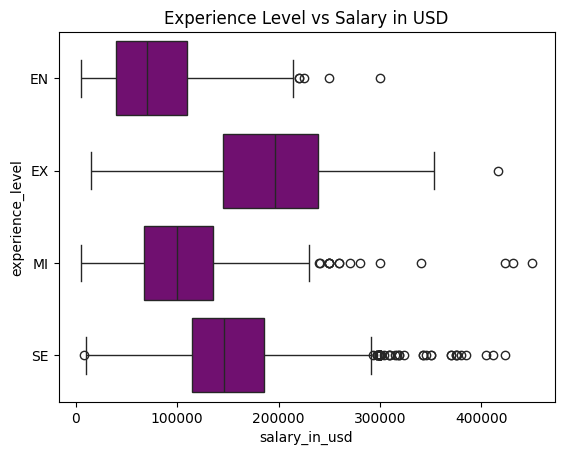

In [10]:
sns.boxplot(
    data=df,
    x="salary_in_usd",
    y="experience_level",
    orient="h",
    color=("purple", 0.3)
).set(title="Experience Level vs Salary in USD")
plt.show()

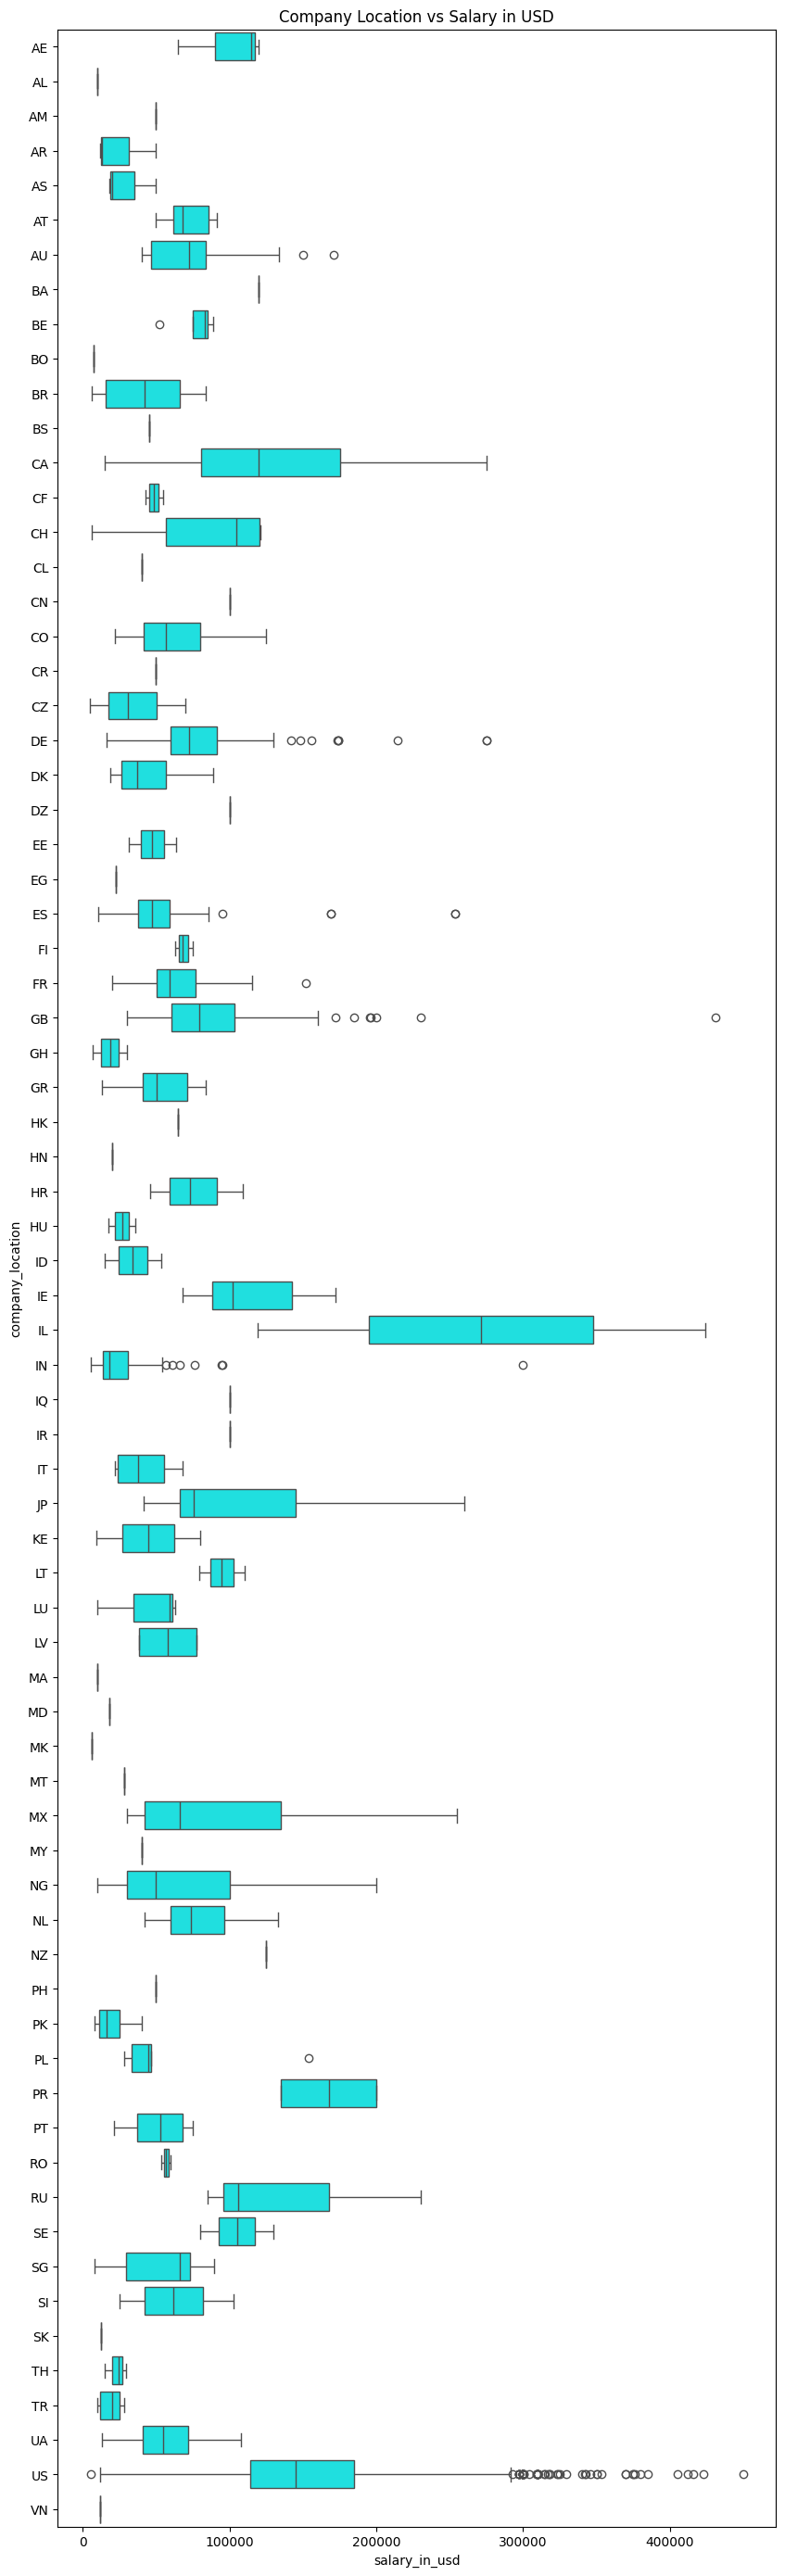

In [11]:
fig, ax = plt.subplots(figsize=(10, 35))
sns.boxplot(
    data=df,
    x="salary_in_usd",
    y="company_location",
    orient="h",
    ax=ax,
    color=("cyan", 0.3)
).set(title="Company Location vs Salary in USD")

plt.show()

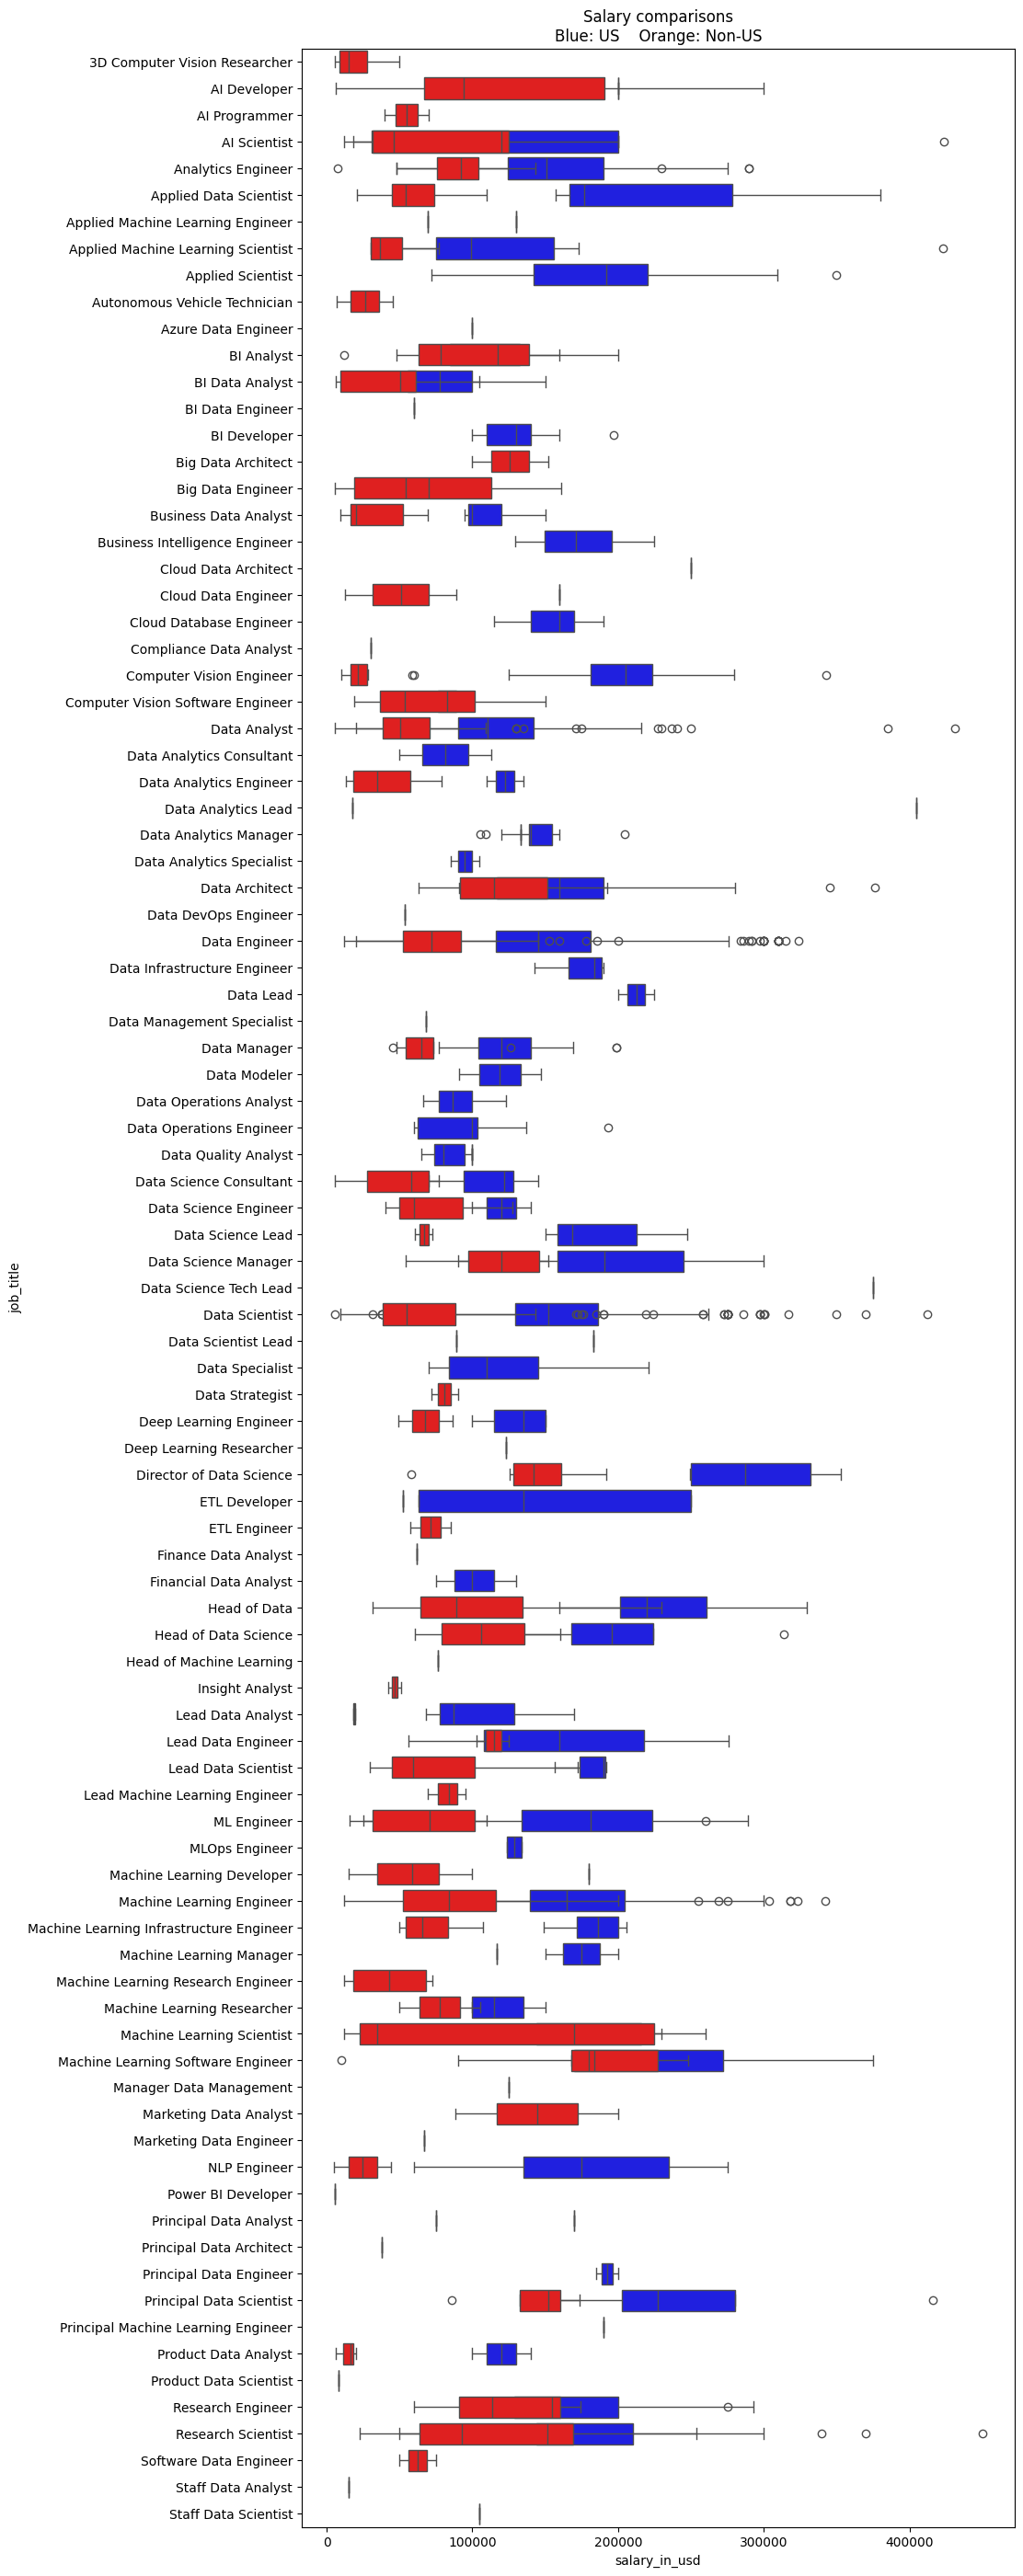

In [12]:
fig, ax = plt.subplots(figsize=(10, 35))

bp = sns.boxplot(
    data=us_companies,
    x="salary_in_usd",
    y="job_title",
    orient="h",
    ax=ax,
    color=("blue", 0.5)
)

sns.boxplot(
    data=df[df['company_location'] != "US"],
    x="salary_in_usd",
    y="job_title",
    orient="h",
    ax=ax,
    color=("red", 0.3)
)

ax.set_title("Salary comparisons\nBlue: US    Orange: Non-US")

plt.show()

### Machine learning for regression predictions

This is to show how we use machine learning models to make forecasts given the data. Notice how `encode_df` function is being used here.

In [13]:
def make_data(df, remove_currency=False):
    y = df["salary_in_usd"]
    exclude_cols = ["salary_in_usd", "salary"]
    if remove_currency:
        exclude_cols.append("salary_currency")
    X = encode_df(df).loc[:, (col for col in df.columns if col not in exclude_cols)]
    return X, y

Data split and forecast using linear regression. This uses a pseudo-matrix-inverse to solve the normal equation.

In [14]:
# US company analysis

X, y = make_data(us_companies, remove_currency=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R2 Score: ", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE Error: ", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 Score:  0.0813531819013712
MAE Error:  42655.81614814446


Random Forest is typically used by most data scientists

In [15]:
rfr = RandomForestRegressor(n_estimators=100, criterion="squared_error")

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

print("R2 Score: ", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE Error: ", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 Score:  0.22373356343554018
MAE Error:  39250.50499426728


Ridge Regressor (L2 regularization)

In [16]:
rr = Ridge()

rr.fit(X_train, y_train)

y_pred = rr.predict(X_test)

print("R2 Score: ", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE Error: ", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 Score:  0.081458124514029
MAE Error:  42651.43887445375


Simple Neural Network. Here I am using two different scalers, neural networks require scaling to avoid divergence of parameters.

In [17]:
mlp = MLPRegressor(hidden_layer_sizes=(64, 128, 64), activation="relu", max_iter=300)

features_scaler = MinMaxScaler()
labels_scaler = RobustScaler()

X_train_scaled = features_scaler.fit_transform(X_train)
X_test_scaled = features_scaler.transform(X_test)
y_train_scaled = labels_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = labels_scaler.transform(y_test.values.reshape(-1, 1))

mlp.fit(X_train_scaled, y_train_scaled.flatten())

y_pred_scaled = mlp.predict(X_test_scaled)

y_pred = labels_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

print("R2 Score: ", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE Error: ", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 Score:  0.16747883830031307
MAE Error:  40741.16483425102


This is a more complex neural network using PyTorch. The idea is to build a more sophisticated neural network.

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def prepare_data(X, y):
    return (torch.tensor(X, dtype=torch.float32).to(device).unsqueeze(0),
            torch.tensor(y, dtype=torch.float32).to(device))


class Regressor(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.Dropout(inplace=True),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.LayerNorm(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.Dropout(inplace=True),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.layers(x)


X_train_t, y_train_t = prepare_data(X_train_scaled, y_train_scaled)
X_test_t, y_test_t = prepare_data(X_test_scaled, y_test_scaled)

model = Regressor(n_features=X_train_scaled.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
n_epochs = 5000
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    out = model(X_train_t)
    train_loss = criterion(out, y_train_t)
    train_loss.backward()
    optimizer.step()
    if epoch % (0.1 * n_epochs) == 0:
        print(f"Epoch {epoch}\tTrain Loss: {train_loss.item():.5e}")


/home/alish/envs/py311/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2036, 1])) that is different to the input size (torch.Size([1, 2036, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 500	Train Loss: 5.56647e-01
Epoch 1000	Train Loss: 5.12382e-01
Epoch 1500	Train Loss: 5.11586e-01
Epoch 2000	Train Loss: 4.92084e-01
Epoch 2500	Train Loss: 4.99154e-01
Epoch 3000	Train Loss: 4.93208e-01
Epoch 3500	Train Loss: 4.85185e-01
Epoch 4000	Train Loss: 4.89115e-01
Epoch 4500	Train Loss: 4.91659e-01
Epoch 5000	Train Loss: 4.76664e-01


In [19]:
with torch.no_grad():
    y_pred_scaled = model(X_test_t).detach().cpu().squeeze(0).numpy()

y_pred = labels_scaler.inverse_transform(y_pred_scaled)

print("R2 Score: ", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE Error: ", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 Score:  0.09647992572332553
MAE Error:  41597.20352963147


So far, the random forest regressor seems to have the lowest error and most prediction power. However, that is still quite low.

Notice how the complex neural network is a worse regressor. Can you figure out why?